In [1]:
%matplotlib inline
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.fftpack import fft, ifft
import math
from scipy import interpolate

# Import data

In [2]:
rows=[]
with open('book1.csv','r') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    for row in reader:
       rows.append([float(x) for x in row]) 
wn = range(-10600,-3999,2)
labels = ['64cm-1','32cm-1','16cm-1','8cm-1','4cm-1']
testRow = rows[2] # 16cm-1
testResolution = 16
targetRow = rows[0] # 64cm-1
targetResolution = 64

# Define NortonBeerStrong
http://uk.mathworks.com/matlabcentral/fileexchange/41477-norton-beer-apodization-filter/content/nortonbeer.m


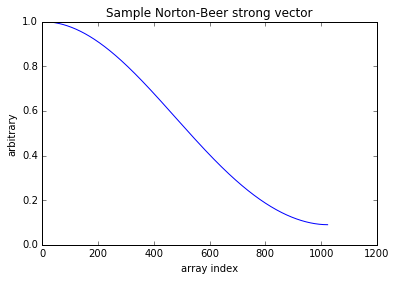

In [3]:
def nortonBeerStrong(u):
    const = [0.09,0,0.5875,0,0.3225]
    v = [const[i] * (1 - u**2)**i for i in range(len(const))]
    return np.sum(v)

def nortonBeerStrongVector(vlen):
    step = 1.0 / vlen
    return [nortonBeerStrong(u) for u in np.arange(0,1,step)]

plt.plot(nortonBeerStrongVector(1024))
plt.title('Sample Norton-Beer strong vector')
plt.ylabel('arbitrary')
plt.xlabel("array index")

plt.show()
    

# Define Mirror

[]

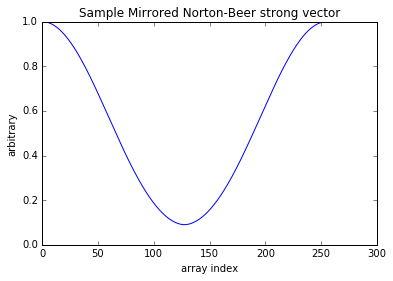

In [4]:
def mirror(v):
    tail =  list(reversed(v))
    result = []
    result.extend(v)
    result.extend(tail)
    return result

plt.plot(mirror(nortonBeerStrongVector(128)))
plt.title('Sample Mirrored Norton-Beer strong vector')
plt.ylabel('arbitrary')
plt.xlabel("array index")
plt.plot()

# Calculate theoretical point interval from given range and optical resolution

In [57]:
theoreticalPoints = 1 +(2 * (10600-4000)/testResolution)
print ("Theoretical points: " + str(theoreticalPoints))
theoreticalResolution = (10600-4000)/(theoreticalPoints-1)
print ("Theoretical resolution: " + str(theoreticalResolution))

Theoretical points: 826.0
Theoretical resolution: 8.0


# Resample to number of points given by resolution

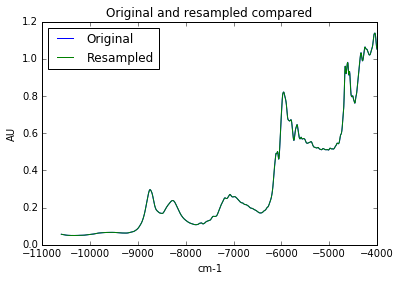

Points original: 3301
Points resampled: 826


In [67]:
tck = interpolate.splrep(wn,testRow,s=0.000001)
wnResample = list(np.arange(-10600,-3999,theoreticalResolution))
resampled = list(interpolate.splev(wnResample,tck,der=0))

plt.plot(wn,testRow, label="Original")
plt.plot(wnResample,resampled, label="Resampled")
plt.title('Original and resampled compared')
plt.ylabel('AU')
plt.xlabel("cm-1")

plt.legend(loc=2)
plt.plot()
plt.show()

print("Points original: " + str (len(testRow)))
print("Points resampled: " + str(len(resampled)))


# Convert AU to 1/reflectance

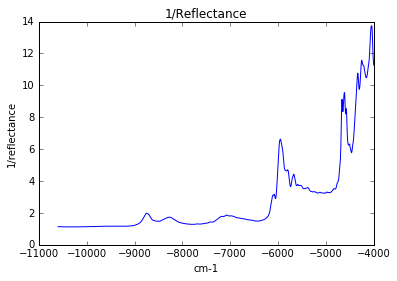

Points:826


In [68]:
resampledR = [10**x for x in resampled]
plt.plot(wnResample,resampledR)
plt.title('1/Reflectance')
plt.ylabel('1/reflectance')
plt.xlabel("cm-1")
plt.show()
print("Points:" + str(len(resampledR)))

# Zero pad to pow2 length

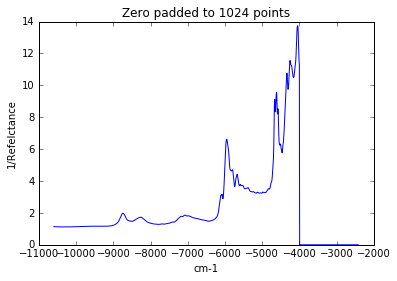

Points: 1024


In [69]:
resampledR.extend([0.0 for x in range(198)])
wnResample.extend([-4000 + i * theoreticalResolution for i in range(1,198+1)])

plt.plot(wnResample,resampledR)
plt.title('Zero padded to 1024 points')
plt.ylabel('1/Refelctance')
plt.xlabel("cm-1")
plt.show()

print ("Points: " + str(len(resampledR)))


# Inverse Transform

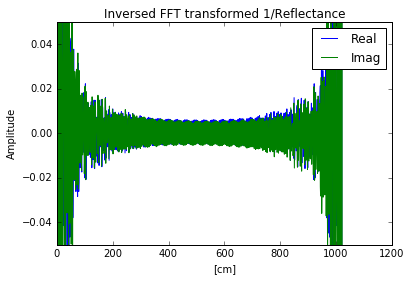

Points:1024


In [72]:
%matplotlib inline
igram = ifft(resampledR)
plt.plot(np.real(igram),label="Real")
plt.plot(np.imag(igram),label="Imag")
plt.ylim((-0.05,0.05))
plt.title('Inversed FFT-transformed of 1/Reflectance')
plt.ylabel('Amplitude')
plt.xlabel("[cm]")
plt.legend()
plt.show()

print ("Points:" + str(len(igram)))

# Truncate Inverse Transform to 1/4

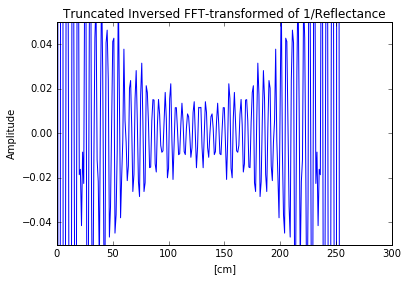

Points:256


In [74]:
truncatedIgram = list(igram[0:128])
truncatedIgram.extend(igram[-128:])

wnTruncated = [wnResample[i*4] for i in range((int)(len(wnResample)/4))]
    
plt.plot(np.real(truncatedIgram))
plt.title('Truncated Inversed FFT-transformed of 1/Reflectance')
plt.ylabel('Amplitude')
plt.xlabel("[cm]")

plt.ylim((-0.05,0.05))
plt.show()

print("Points:" + str(len(truncatedIgram)))

# Apodize

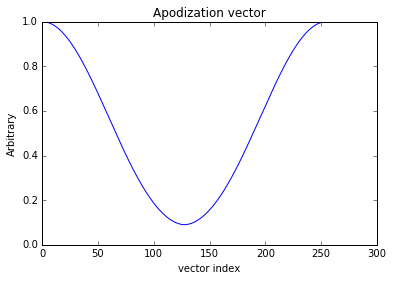

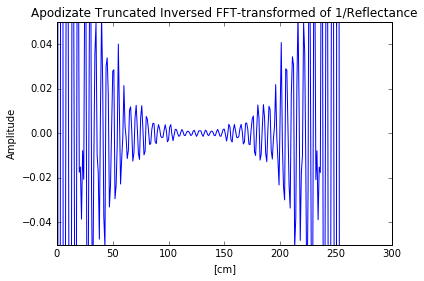

In [75]:
aVector = mirror(nortonBeerStrongVector(128))
plt.plot(aVector)
plt.title('Apodization vector')
plt.ylabel('Arbitrary')
plt.xlabel("vector index")
plt.show()

apodizedIgram = np.multiply(truncatedIgram, aVector)
plt.plot(np.real(apodizedIgram))
plt.title('Apodizate Truncated Inversed FFT-transformed of 1/Reflectance')
plt.ylabel('Amplitude')
plt.xlabel("[cm]")
plt.ylim((-0.05,0.05))
plt.show()

# FFT Transform

In [41]:
recreatedi = fft(apodizedIgram)
recreatedRowR = np.real(np.conj(recreatedi))
recreatedRow = np.log10(recreatedRowR)

# Compare with original (16cm-1)

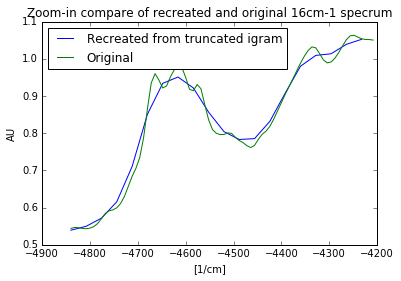

In [76]:
plt.plot(wnTruncated[180:200],recreatedRow[180:200], label="Recreated from truncated igram")
plt.plot(wnResample[720:800],resampled[720:800], label="Original")
plt.title('Zoom-in compare of recreated and original 16cm-1 specrum')
plt.ylabel('AU')
plt.xlabel("[1/cm]")

plt.legend(loc=2)
plt.show()

# Resample

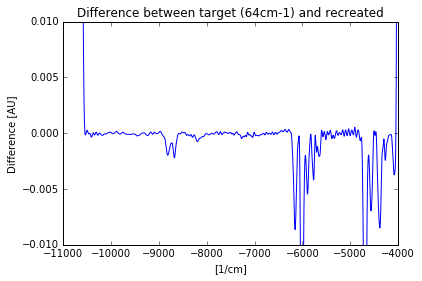

Std from target:0.00241467299596


In [79]:

tckRecrated = interpolate.splrep(wnTruncated,recreatedRow,s=0.000001)
resampledRecreatedRow = interpolate.splev(wn,tckRecrated,der=0)
diff = np.subtract(targetRow,resampledRecreatedRow)

plt.plot(wn[0:-10],diff[0:-10])
plt.title('Difference between target (64cm-1) and recreated')
plt.ylabel('Difference [AU]')
plt.xlabel("[1/cm]")

plt.ylim([-0.01,0.01])
plt.show()
print("Std from target:" + str(np.std(diff[400:-400])))
